# Infin8's transactions classification

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import datetime
import re
import unicodedata
from fuzzywuzzy import fuzz
from typing import Any, Dict, Union
import dask.dataframe as dd
import multiprocessing
import string
warnings.filterwarnings('ignore')

/Users/stavrostheocharis/projects/wyre/.env/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/stavrostheocharis/projects/wyre/.env/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### Import infin8 data

In [2]:
transactions_df = pd.read_json('../data/01_raw/infin8/transactions.json')
accounts_df = pd.read_json('../data/01_raw/infin8/accounts.json')

### Quick display

In [8]:
display(transactions_df.head(3))
print("---------------------------------------------------------------------------")
display(accounts_df.head(3))

_id                      user     bankId  \
0  605406c545f27f3a986d6b6f  5f8f4018c489a9d2a82e1ab4  alphabank   
1  605406c545f27fc96c6d6b70  5f8f4018c489a9d2a82e1ab4  alphabank   
2  605406c545f27f06736d6b71  5f8f4018c489a9d2a82e1ab4  alphabank   

                    accountId  amount  balance           description  \
0  eyJpIjo0MjcwMTE4LCJzIjoyfQ     5.0   627.95          WWW.AODOS.GR   
1  eyJpIjo0MjcwMTE4LCJzIjoyfQ    82.5   622.95           EUROBANK GR   
2  eyJpIjo0MjcwMTE4LCJzIjoyfQ    10.1   540.45  KARACHALIOS PANAGIOT   

                       date     type currency  
0 2021-03-18 00:00:00+00:00  EXPENSE      EUR  
1 2021-03-18 00:00:00+00:00  EXPENSE      EUR  
2 2021-03-18 00:00:00+00:00  EXPENSE      EUR

---------------------------------------------------------------------------


user    bankId                    accountId    type  \
0  5f3d70fdeffab3672d916533  eurobank  GR5302600190000510101213013  saving   
1  5f3d70fdeffab3672d916533  eurobank  GR9202603640000180100252511  saving   
2  5f3d70fdeffab3672d916533  eurobank  GR9602606770000180103169514  saving   

                        number currency  balance  
0  GR5302600190000510101213013      EUR     0.00  
1  GR9202603640000180100252511      EUR     2.07  
2  GR9602606770000180103169514      EUR   221.92

#### Total transactions are

In [9]:
len(transactions_df)

26883

### Check unique types of accounts

In [34]:
accounts_df["type"].drop_duplicates()

0       saving
4     checking
6         card
9        debit
30       other
Name: type, dtype: object

### Check unique banks in dataset

In [11]:
transactions_df.bankId.drop_duplicates()


0       alphabank
5             nbg
47        piraeus
79       eurobank
247       revolut
2053    ingdirect
7606          N26
Name: bankId, dtype: object

### Refactor transactions and accounts as needed for wysely processes

In [3]:
# Create is income column
transactions_df["is_income"] = transactions_df.apply(lambda x: True if x["type"]=="INCOME" else False,axis=1)
# Delete old type column
transactions_df = transactions_df.drop(["type"], axis=1)
# Create iban column
transactions_df["iban"]=transactions_df["accountId"]
# Drop old account_id column
transactions_df = transactions_df.drop(["accountId"], axis=1)
# Create empty type, mcc and classification columns as transaction base defines
transactions_df["type"]=None
transactions_df["mcc"]=None
transactions_df["classification"]=None


In [4]:
accounts_df["iban"] = accounts_df["accountId"]
accounts_df = accounts_df.drop(["accountId"], axis=1)
accounts_df["pan"] = None

#### Need to check if accounts match with transactions. This has to be done only for expenses. Incoming classification does not require accounts

#### So, split transactions

In [5]:
incoming_transactions_df = transactions_df.loc[transactions_df["is_income"]==True].reset_index(drop=True)
outgoing_transactions_df = transactions_df.loc[transactions_df["is_income"]==False].reset_index(drop=True)

In [6]:
def find_piraeus_mcc_in_description(description):
    mcc = None
    if description:
        splitted_des = description.split()
        if len(splitted_des)>1:
            if (splitted_des[0]=="CARD") & (splitted_des[1]=="PURCHASE"):
                mcc = description[-4:]
                
    return mcc


In [9]:
piraeus = outgoing_transactions_df[outgoing_transactions_df["bankId"]=="piraeus"].reset_index(drop=True)
other = outgoing_transactions_df[outgoing_transactions_df["bankId"]!="piraeus"].reset_index(drop=True)

In [10]:
piraeus["mcc"] = piraeus.apply(lambda x: find_piraeus_mcc_in_description(x["description"]), axis=1)


In [11]:
outgoing_transactions_df = pd.DataFrame()
outgoing_transactions_df = outgoing_transactions_df.append(piraeus, ignore_index=True)
outgoing_transactions_df = outgoing_transactions_df.append(other, ignore_index=True)

In [6]:
print("Length of incoming transactions is: ",len(incoming_transactions_df))
print("Length of outgoing transactions is: ",len(outgoing_transactions_df))

Length of incoming transactions is:  9583
Length of outgoing transactions is:  17300


### Check if all iban rows in transactions are included in accounts


#### Find unique accounts through transactions iban

In [12]:
unique_accounts_in_outgoing_transactions = outgoing_transactions_df["iban"].drop_duplicates().reset_index(drop=True)
unique_accounts_in_outgoing_transactions

0               GR0301715790006579148171262
1               GR1601720400005040092971023
2               GR1801715790006579136523911
3               GR0301719120006912143697470
4               GR1701721530005153060388333
                       ...                 
310              eyJpIjoyNDg0NTQwLCJzIjoxfQ
311    6036f142-58b2-450c-b447-37f5b406ea27
312    ad3b09ff-9813-4f80-a666-9821e40dcf8e
313    7019d5b7-1e74-4f07-8970-a5d7ac698645
314    d7c95dd5-2568-401d-83bd-1d409cb939c6
Name: iban, Length: 315, dtype: object

#### Find unique accounts in accounts

In [13]:
unique_accounts_in_accounts = accounts_df["iban"].drop_duplicates().reset_index(drop=True)
unique_accounts_in_accounts

0               GR5302600190000510101213013
1               GR9202603640000180100252511
2               GR9602606770000180103169514
3               GR1802606770000110103449748
4               GR5702604580000460200485159
                       ...                 
310                        405784******7861
311                        516732******7171
312             GR1902600310000370200945572
313             GR1601720400005040092971023
314    e2065574-344c-65c8-061e-541a34ef6d43
Name: iban, Length: 315, dtype: object

#### Find common and uncommon elements (accounts)

In [14]:
# union of the series
union = pd.Series(np.union1d(unique_accounts_in_outgoing_transactions, unique_accounts_in_accounts))
# intersection of the series
intersect = pd.Series(np.intersect1d(unique_accounts_in_outgoing_transactions, unique_accounts_in_accounts))
# uncommon elements in both the series 
notcommonseries = union[~union.isin(intersect)]

#### So the common accounts are:

In [19]:
intersect

0      04b1d585-18c1-477c-88e2-4113eed025a2
1      09a10bd4-c42f-400c-aa66-3b8a3002a18d
2      0c1050ed-3b1e-a6c4-66df-406261541572
3      10760350-3746-4f42-8192-76bf19ed588a
4      11a6cf6d-1eb3-c997-336e-74390fd36b3a
                       ...                 
193              eyJpIjozNzQ1ODI3LCJzIjoxfQ
194    f03fbab0-1282-f774-c7b6-3d9d71bdaec5
195    f409c568-7c59-270c-4efd-27451a5737ae
196    f49132aa-2f80-1a67-2da7-0781113b40fa
197    f5b2dd5b-2121-45ec-412f-7cdc8fed1bce
Length: 198, dtype: object

#### Only the ougoing transactions of these acounts can be classified correctly through the classification pipeline. The remaining can be just pass through one of the expenses pipelines (if wanted)

In [15]:
### Find these transactions

intersected_accounts_df = pd.DataFrame(intersect).reset_index(drop=True)
intersected_accounts_df.columns=["iban"]

In [16]:
outgoing_transactions_to_use_df = pd.merge(outgoing_transactions_df, intersected_accounts_df, on='iban')
len(outgoing_transactions_to_use_df)

11100

#### So, 6300 transactions were dropped

#### ingdirect has 2 checking accounts and no cards, while N26 has only one checking accounts and no cards. Revolut has multiple checking and saving accounts but no cards

### Connect back the incoming with the new outgoing transactions

In [17]:
combined_transactions_df = pd.DataFrame()
combined_transactions_df = combined_transactions_df.append(incoming_transactions_df, ignore_index=True)
combined_transactions_df = combined_transactions_df.append(outgoing_transactions_to_use_df, ignore_index=True)


#### Display the combined dataframe

In [12]:
combined_transactions_df.head(2)

_id                      user     bankId   amount  \
0  6052b57a45f27f39856d6b66  5f8f4018c489a9d2a82e1ab4        nbg  1193.88   
1  6054067345f27f8b7c6d6b6b  5f3d70fdeffab3672d916533  alphabank     1.00   

   balance        description                      date currency  is_income  \
0  1194.45      ETHNIKI AEEGA 2021-03-17 00:00:00+00:00      EUR       True   
1    13.49  ΑLΡΗΑ ΤΕSΤ ΙΝFΙΝ8 2021-03-17 00:00:00+00:00      EUR       True   

                                   iban  type   mcc classification  
0  f03fbab0-1282-f774-c7b6-3d9d71bdaec5  None  None           None  
1            eyJpIjoyOTE2Nzg0LCJzIjoxfQ  None  None           None

In [18]:
combined_transactions_df.loc[combined_transactions_df["bankId"]=="revolut", "iban"]="LT413250000000000000"

In [19]:
new_revolut_account_data = ["5f3d70fdeffab3672d916533", "revolut", "checking", "LT413250000000000000", "EUR", 0, "LT413250000000000000", None]
new_revolut_account_df = pd.DataFrame(new_revolut_account_data).T
new_revolut_account_df.columns = ["user", "bankId", "type", "number", "currency", "balance", "iban", "pan"]

accounts_df = accounts_df.append(new_revolut_account_df, ignore_index=True)

In [20]:
def no_iban(iban):
    if len(iban) !=27:
        return True
    else:
        return False

In [21]:
eurobank_transactions = combined_transactions_df.loc[(combined_transactions_df["bankId"]=="eurobank")].reset_index(drop=True)
outgoing_eurobank_transactions = eurobank_transactions.loc[eurobank_transactions["is_income"]==False].reset_index(drop=True)
incoming_eurobank_transactions = eurobank_transactions.loc[eurobank_transactions["is_income"]==True].reset_index(drop=True)
other_transactions = combined_transactions_df.loc[(combined_transactions_df["bankId"]!="eurobank")].reset_index(drop=True)

outgoing_eurobank_transactions["to_drop"] = outgoing_eurobank_transactions.apply(lambda x: no_iban(x["iban"]), axis=1)
outgoing_kept_eurobank_transactions = outgoing_eurobank_transactions.loc[outgoing_eurobank_transactions["to_drop"]==False].reset_index(drop=True)
outgoing_kept_eurobank_transactions = outgoing_kept_eurobank_transactions.drop(['to_drop'], axis=1)


combined_transactions_df = pd.DataFrame()
combined_transactions_df = combined_transactions_df.append(incoming_eurobank_transactions, ignore_index=True)
combined_transactions_df = combined_transactions_df.append(outgoing_kept_eurobank_transactions, ignore_index=True)
combined_transactions_df = combined_transactions_df.append(other_transactions, ignore_index=True).reset_index(drop=True)



In [22]:
def split_to_card_and_remittance_expenses(
    transactions_df: pd.DataFrame,
):
    """ It gets as input outgoing transactions and splits them to card expenses and remittance expenses"""

    card_expenses_df = transactions_df.loc[
        (transactions_df["type"] == "debit")
        | (transactions_df["type"] == "credit")
        | (transactions_df["type"] == "card")
    ]
    card_expenses_df = card_expenses_df.reset_index(drop=True)

    remittance_expenses_df = transactions_df.loc[
        (transactions_df["type"] != "debit")
        & (transactions_df["type"] != "credit")
        & (transactions_df["type"] != "card")
    ]
    remittance_expenses_df = remittance_expenses_df.reset_index(drop=True)

    return dict(
        card_expenses_transactions=card_expenses_df,
        remittance_expenses_transactions=remittance_expenses_df,
    )

def process_nbg(card_expenses, remittance_expenses, temp_remittance_expenses):
    for i, card_row in card_expenses.iterrows():
        for j, rem_row in temp_remittance_expenses.iterrows():
            if card_row["user"] == rem_row["user"]:
                processed_card_description = remove_intro_of_card_description(card_row["description"])
                fuzz_partial_levenshtein_similarity = (
                    fuzz.partial_ratio(processed_card_description, rem_row["description"]) / 100
                )

                if (fuzz_partial_levenshtein_similarity > 0.86) & (
                    rem_row["amount"] == card_row["amount"]
                ):
                    card_expenses.loc[i, "duplicated_with"] = rem_row["provider_id"]
                    remittance_expenses.loc[j, "duplicated_with"] = card_row["provider_id"]
                    temp_remittance_expenses = temp_remittance_expenses.drop([j])
                    break

    return card_expenses, remittance_expenses


def process_alpha(card_expenses, remittance_expenses, temp_remittance_expenses):
    for i, card_row in card_expenses.iterrows():
        for j, rem_row in temp_remittance_expenses.iterrows():
            if card_row["user"] == rem_row["user"]:
                processed_remittance_description = convert_alpha_characters(rem_row["description"])
                fuzz_partial_levenshtein_similarity = (
                    fuzz.partial_ratio(processed_remittance_description, card_row["description"]) / 100
                )

                if (fuzz_partial_levenshtein_similarity > 0.86) & (
                    rem_row["amount"] == card_row["amount"]
                ):
                    card_expenses.loc[i, "duplicated_with"] = rem_row["provider_id"]
                    remittance_expenses.loc[j, "duplicated_with"] = card_row["provider_id"]
                    temp_remittance_expenses = temp_remittance_expenses.drop([j])
                    break

    return card_expenses, remittance_expenses

def identify_duplicated_transactions(card_expenses, remittance_expenses, bank):

    if "duplicated_with" not in card_expenses.columns:
        card_expenses["duplicated_with"] = None
        remittance_expenses["duplicated_with"] = None

    card_expenses_of_bank_df = card_expenses.loc[card_expenses["bank"] == bank].reset_index(
        drop=True
    )
    remittance_expenses_of_bank_df = remittance_expenses.loc[
        remittance_expenses["bank"] == bank
    ].reset_index(drop=True)

    card_expenses_of_other_bank_df = card_expenses.loc[card_expenses["bank"] != bank].reset_index(
        drop=True
    )
    remittance_expenses_of_other_bank_df = remittance_expenses.loc[
        remittance_expenses["bank"] != bank
    ].reset_index(drop=True) 

    card_expenses_of_bank_df = card_expenses_of_bank_df.sort_values("description").reset_index(
        drop=True
    )
    remittance_expenses_of_bank_df = remittance_expenses_of_bank_df.sort_values(
        "description"
    ).reset_index(drop=True)

    # Temp remittance expenses for the loop
    temp_remittance_expenses_of_bank_df = remittance_expenses_of_bank_df.copy()

    if bank == "nbg":
        dupl_card_expenses_df, dupl_remittance_expenses_df = process_nbg(
            card_expenses_of_bank_df,
            remittance_expenses_of_bank_df,
            temp_remittance_expenses_of_bank_df,
        )
    else:
        if bank == "alpha":
            dupl_card_expenses_df, dupl_remittance_expenses_df = process_alpha(
                card_expenses_of_bank_df,
                remittance_expenses_of_bank_df,
                temp_remittance_expenses_of_bank_df,
            )
        else:
            dupl_card_expenses_df = pd.DataFrame()
            dupl_remittance_expenses_df = pd.DataFrame()

    final_card_expenses = card_expenses_of_other_bank_df.append(
        dupl_card_expenses_df, ignore_index=True
    )
    final_remittance_expenses = remittance_expenses_of_other_bank_df.append(
        dupl_remittance_expenses_df, ignore_index=True
    )

    return dict(
        identified_duplicated_card_expenses=final_card_expenses,
        identified_duplicated_remittance_expenses=final_remittance_expenses,
    )

def remove_intro_of_card_description(description):
    """ It removes "ΑΓΟΡΑ - " based on nbg card expenses and removes more than one spaces"""
    processed_description = re.sub("ΑΓΟΡΑ - +", "", description)
    processed_description = re.sub(" +", " ", processed_description)

    return processed_description

def convert_alpha_characters(description: str) -> str:
    """Converts the mixed letters of greek and english of a word to only english"""
    greek = False
    english = False
    new_description = ""
    for word in description.split():
        for letter in word:
            if is_english(letter):
                english = True
            else:
                greek = True
            if (english == True) & (greek == True):
                break
    if (english == True) & (greek == True):
        for word in description.split():
                greek_alphabet = "ΑαΒβΓγΔδΕεΖζΗηΘθΙιΚκΛλΜμΝνΞξΟοΠπΡρΣσςΤτΥυΦφΧχΨψΩω"
                english_alphabet = "AaBbGgDdEeZzHhJjIiKkLlMmNnXxOoPpPpSssTtYyFfXxYyWw"
                transform = str.maketrans(greek_alphabet, english_alphabet)
                new_description = new_description + " " + word.translate(transform)

        return new_description[1:]
    else:
        return description

    
def is_english(character):
    """Checks if a character is english"""
    try:
        character.encode(encoding="utf-8").decode("ascii")
    except UnicodeDecodeError:
        return False
    else:
        return True

In [23]:
def reclassify_duplicated_remittance_expenses(remittance_expenses_df, card_expenses_df):
    """ 
    Gets transactions with duplicated_with attribute and keeps the right classification of the duplicates
    which is the once in cards
    """
    # Split remitance expenses to duplicated and non duplicated
    non_duplicated_remittance_expenses_df = remittance_expenses_df.loc[
        remittance_expenses_df["duplicated_with"].isna()
    ].reset_index(drop=True)
    duplicated_remittance_expenses_df = remittance_expenses_df.loc[
        remittance_expenses_df["duplicated_with"].notna()
    ].reset_index(drop=True)
    # Drop the classification column because will be created the new one
    duplicated_remittance_expenses_df = duplicated_remittance_expenses_df.drop(
        ["classification", "confidence"], axis=1
    )
    # Merge duplicated remitance expenses with card expenses based on the kept ids
    merged_duplicated_remittance_expenses_df = pd.merge(
        duplicated_remittance_expenses_df,
        card_expenses_df[["classification", "provider_id", "confidence"]],
        left_on="duplicated_with",
        right_on="provider_id",
        how="left",
    )
    # Drop the unnecessary created columns and rename the id column
    if "provider_id_y" in merged_duplicated_remittance_expenses_df.columns:
        merged_duplicated_remittance_expenses_df = merged_duplicated_remittance_expenses_df.drop(
            ["provider_id_y"], axis=1
        )
    if "provider_id_x" in merged_duplicated_remittance_expenses_df.columns:
        merged_duplicated_remittance_expenses_df = merged_duplicated_remittance_expenses_df.rename(
            columns={"provider_id_x": "provider_id"}
        )
    # Append to the non duplicated remitance expenses the new classified remittance expenses
    final_remittance_expenses_df = non_duplicated_remittance_expenses_df.append(
        merged_duplicated_remittance_expenses_df, ignore_index=True
    )

    return final_remittance_expenses_df


## Classification

### Import necessary pipelines and catalogs for the classification

In [24]:
from kedro.runner import SequentialRunner
from kedro.io import DataCatalog, MemoryDataSet
from kedro.extras.datasets.tensorflow import TensorFlowModelDataset
from kedro.extras.datasets.yaml import YAMLDataSet
from kedro.extras.datasets.pandas import CSVDataSet
from kedro.extras.datasets.pickle import PickleDataSet

# Set up paths
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.wyre.composers.descriptions import create_classify_transactions_full_pipeline

from pathlib import Path
from typing import Any
from kedro.io import DataCatalog, MemoryDataSet
from kedro.extras.datasets.tensorflow import TensorFlowModelDataset
from kedro.extras.datasets.yaml import YAMLDataSet
from kedro.extras.datasets.pandas import CSVDataSet
from kedro.extras.datasets.pickle import PickleDataSet
import pandas as pd
import bios

def get_data_catalog(
    input_transactions: pd.DataFrame,
    *,
    input_products: pd.DataFrame = pd.DataFrame(),
    input_accounts: pd.DataFrame = pd.DataFrame(),
) -> DataCatalog:
    parameters = bios.read("../conf/base/parameters.yml")
    return DataCatalog(
        {
            # MemoryDataSet
            "input_products": MemoryDataSet(input_products),
            "input_accounts": MemoryDataSet(input_accounts),
            "input_transactions": MemoryDataSet(input_transactions),
            "params:default_probability_weights": MemoryDataSet(
                parameters["default_probability_weights"]
            ),
            "params:qualitative_thresholds": MemoryDataSet(parameters["qualitative_thresholds"]),
            "params:dp_features_thresholds": MemoryDataSet(parameters["dp_features_thresholds"]),
            "params:incoming_description_classifier_model_params": MemoryDataSet(
                parameters["incoming_description_classifier_model_params"]
            ),
            "params:transaction_classifier_model_params": MemoryDataSet(
                parameters["transaction_classifier_model_params"]
            ),
            "params:calculate_income_stability_score_params": MemoryDataSet(["transfers"]),
            "params:cash_withdrawal": MemoryDataSet(parameters["cash_withdrawal"]),
            "params:rent": MemoryDataSet(parameters["rent"]),
            "params:gambling": MemoryDataSet(parameters["gambling"]),
            "params:loan_and_repayment": MemoryDataSet(parameters["loan_and_repayment"]),
            "params:is_income": MemoryDataSet(parameters["is_income"]),
            "params:is_expense": MemoryDataSet(parameters["is_expense"]),
            "params:is_training": MemoryDataSet(True),
            "params:card_expenses_description_classifier_model_params": MemoryDataSet(
                parameters["card_expenses_description_classifier_model_params"]
            ),
            "params:remittance_expenses_description_classifier_model_params": MemoryDataSet(
                parameters["remittance_expenses_description_classifier_model_params"]
            ),
            "params:banks_to_change": MemoryDataSet(parameters["banks_to_change"]),
            # TensorFlowModelDataset
            "incoming_description_classifier_model": TensorFlowModelDataset(
                "../data/06_models/incoming_description_classifier_model"
            ),
            "transaction_classifier_model": TensorFlowModelDataset(
                "../data/06_models/transaction_classifier_model"
            ),
            "card_expenses_description_classifier_model": TensorFlowModelDataset(
                "../data/06_models/card_expenses_description_classifier_model"
            ),
            "remittance_expenses_description_classifier_model": TensorFlowModelDataset(
                "../data/06_models/remittance_expenses_description_classifier_model"
            ),
            # PickleDataSet
            "incoming_description_tokenizer": PickleDataSet(
                "../data/06_models/incoming_description_tokenizer/incoming_description_tokenizer.pickle"
            ),
            # YAMLDataSet
            "incoming_description_classifier_y_labels": YAMLDataSet(
                "../data/06_models/labels/incoming_description_classifier_y_labels.yaml"
            ),
            "transaction_classifier_y_labels": YAMLDataSet(
                "../data/05_model_input/transaction_classifier_model/transaction_classifier_y_labels.yaml"
            ),
            "card_expenses_description_classifier_y_labels": YAMLDataSet(
                "../data/06_models/labels/card_expenses_description_classifier_y_labels.yaml"
            ),
            "remittance_expenses_description_classifier_y_labels": YAMLDataSet(
                "../data/06_models/labels/remittance_expenses_description_classifier_y_labels.yaml"
            ),
            # CSVDataSet
            "expenses_categories_bucket": CSVDataSet(
                "../data/04_feature/bag_of_words/expenses_categories_bucket.csv"
            ),
            "essential_lifestyle_wysely_categories": CSVDataSet(
                "../data/04_feature/bag_of_words/essential_lifestyle_wysely_categories.csv"
            ),
            "bank_digits": CSVDataSet(
                "../data/04_feature/bag_of_words/bank_digits.csv", load_args=dict(dtype=object)
            ),
            "mcc_codes_to_wysely_categories": CSVDataSet(
                "../data/04_feature/bag_of_words/mcc_codes_to_wysely_categories.csv"
            ),
            "card_expenses_description_tokenizer": PickleDataSet(
                "../data/06_models/card_expenses_description_tokenizer/card_expenses_description_tokenizer.pickle"
            ),
            "card_expenses_words_to_remove": CSVDataSet(
                "../data/04_feature/bag_of_words/card_expenses_words_to_remove.csv"
            ),
            "remittance_expenses_description_tokenizer": PickleDataSet(
                "../data/06_models/remittance_expenses_description_tokenizer/remittance_expenses_description_tokenizer.pickle"
            ),
        }
    )

runner = SequentialRunner()


In [25]:
catalog = get_data_catalog(input_transactions=combined_transactions_df,input_accounts=accounts_df)
pipeline = create_classify_transactions_full_pipeline()
final_transactions = runner.run(pipeline, catalog)


/Users/stavrostheocharis/projects/wyre/.env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
final_transactions_df = final_transactions["full_classification_pipeline_output"]
final_transactions_df = final_transactions_df.drop(["index"], axis=1)

/Users/stavrostheocharis/projects/wyre/.env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
final_transactions_df.rename(columns = {'bankId':'bank'}, inplace = True)
final_transactions_df.loc[final_transactions_df["bank"]=="alphabank", "bank"]="alpha"
final_transactions_df.rename(columns = {'_id':'provider_id'}, inplace = True)


/Users/stavrostheocharis/projects/wyre/.env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
def split_incoming_and_outgoing(transactions_df: pd.DataFrame) -> Dict[str, pd.DataFrame]:
    incoming_transactions_df = transactions_df[transactions_df["is_income"] == True].reset_index(
        drop=True
    )
    outgoing_transactions_df = transactions_df[transactions_df["is_income"] == False].reset_index(
        drop=True
    )
    return dict(
        incoming_transactions=incoming_transactions_df,
        outgoing_transactions=outgoing_transactions_df,
    )

/Users/stavrostheocharis/projects/wyre/.env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
splitted_transactions_df = split_incoming_and_outgoing(final_transactions_df)
incoming_transactions_df = splitted_transactions_df["incoming_transactions"]
outgoing_transactions_df = splitted_transactions_df["outgoing_transactions"]

In [39]:
dict_transactions = split_to_card_and_remittance_expenses(outgoing_transactions_df)
card_expenses_transactions = dict_transactions["card_expenses_transactions"]
remittance_expenses_transactions = dict_transactions["remittance_expenses_transactions"]

/Users/stavrostheocharis/projects/wyre/.env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
a = identify_duplicated_transactions(card_expenses_transactions, remittance_expenses_transactions, "nbg")


/Users/stavrostheocharis/projects/wyre/.env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
identified_duplicated_card_expenses = a["identified_duplicated_card_expenses"]
identified_duplicated_remittance_expenses = a["identified_duplicated_remittance_expenses"]
#b = identified_duplicated_card_expenses.loc[identified_duplicated_card_expenses["duplicated_with"].notna()]

In [42]:
c = identify_duplicated_transactions(identified_duplicated_card_expenses, identified_duplicated_remittance_expenses, "alpha")

In [43]:
final_identified_duplicated_card_expenses = c["identified_duplicated_card_expenses"]
final_identified_duplicated_remittance_expenses = c["identified_duplicated_remittance_expenses"]

/Users/stavrostheocharis/projects/wyre/.env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
new_final_identified_duplicated_remittance_expenses = reclassify_duplicated_remittance_expenses(final_identified_duplicated_remittance_expenses, final_identified_duplicated_card_expenses)

/Users/stavrostheocharis/projects/wyre/.env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
finalized_transactions_df = pd.DataFrame()
finalized_transactions_df = finalized_transactions_df.append(final_identified_duplicated_card_expenses, ignore_index=True)
finalized_transactions_df = finalized_transactions_df.append(incoming_transactions_df, ignore_index=True)
finalized_transactions_df = finalized_transactions_df.append(new_final_identified_duplicated_remittance_expenses, ignore_index=True)


/Users/stavrostheocharis/projects/wyre/.env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
finalized_transactions_df.loc[(finalized_transactions_df["is_income"]==False) & (finalized_transactions_df["type"]!="card") & (finalized_transactions_df["type"]!="debit") & (finalized_transactions_df["classification"]=="other") & (finalized_transactions_df["duplicated_with"].isna()), "classification"]="transfer"

/Users/stavrostheocharis/projects/wyre/.env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Display the classified transactions

### Find inner transfers

In [48]:
# Set up paths
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.wyre._01_data_engineering.nodes import flag_inner_transfers

/Users/stavrostheocharis/projects/wyre/.env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Find unique users

In [49]:
users = finalized_transactions_df.drop_duplicates(subset="user")
users = users.user.reset_index(drop=True)
users = users.to_numpy(users)

In [50]:
new_flagged_transactions_df = pd.DataFrame()

for user in users:
    temp_transactions = finalized_transactions_df.loc[finalized_transactions_df["user"]==user].reset_index(drop=True)
    incoming_temp_transactions = temp_transactions.loc[temp_transactions["is_income"]==True].reset_index(drop=True)
    outgoing_temp_transactions = temp_transactions.loc[temp_transactions["is_income"]==False].reset_index(drop=True)

    result = flag_inner_transfers(incoming_temp_transactions, outgoing_temp_transactions)
    new_flagged_transactions_df = new_flagged_transactions_df.append(result["incoming_transactions"])
    new_flagged_transactions_df = new_flagged_transactions_df.append(result["outgoing_transactions"])

In [51]:
new_flagged_transactions_df = new_flagged_transactions_df.reset_index(drop=True)
new_flagged_transactions_df.head(3)

/Users/stavrostheocharis/projects/wyre/.env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


provider_id                      user      bank  amount  \
0  603c4c3245f27f20996d6991  5f3d70fdeffab3672d916533  eurobank   30.00   
1  603cb22245f27fc3086d6a4a  5f3d70fdeffab3672d916533  eurobank    0.01   
2  602f1d3045f27f3d4f6d6889  5f3d70fdeffab3672d916533  eurobank   30.00   

   balance             description                      date currency  \
0   221.91                 25-2-21 2021-03-01 00:00:00+00:00      EUR   
1   221.92  POI E2E123-RECEIVERREF 2021-03-01 00:00:00+00:00      EUR   
2   241.91                 17-2-21 2021-02-18 00:00:00+00:00      EUR   

   is_income                         iban  type   mcc classification  \
0       True  GR9602606770000180103169514  None  None       transfer   
1       True  GR9602606770000180103169514  None  None       transfer   
2       True  GR9602606770000180103169514  None  None       transfer   

   confidence duplicated_with  is_inner  
0    0.769408             NaN     False  
1    0.769408             NaN     False  
2    0.769408             NaN     False

In [52]:
new_flagged_transactions_df.loc[new_flagged_transactions_df["is_inner"]==True, "classification"]="inner_transfer"

/Users/stavrostheocharis/projects/wyre/.env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
new_flagged_transactions_df

/Users/stavrostheocharis/projects/wyre/.env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


provider_id                      user      bank  amount  \
0      603c4c3245f27f20996d6991  5f3d70fdeffab3672d916533  eurobank   30.00   
1      603cb22245f27fc3086d6a4a  5f3d70fdeffab3672d916533  eurobank    0.01   
2      602f1d3045f27f3d4f6d6889  5f3d70fdeffab3672d916533  eurobank   30.00   
3      6027343145f27f42f96d6839  5f3d70fdeffab3672d916533  eurobank   30.00   
4      601ca87945f27f71736d678a  5f3d70fdeffab3672d916533  eurobank   30.00   
...                         ...                       ...       ...     ...   
20398  5f67063aec036e3fe06fa072  5f670458ec036e67456f9fd6   revolut  100.00   
20399  5f5b29e7ec036ecf476f7f44  5f5b28ddec036e8e3a6f7f3d       nbg   13.00   
20400  5f560c2b9479a659892a5890  5f560b6d9479a66b1f2a5887   piraeus   19.58   
20401  5f560c2b9479a6ebb92a5891  5f560b6d9479a66b1f2a5887   piraeus    0.40   
20402  5f560c2b9479a68a752a5895  5f560b6d9479a66b1f2a5887   piraeus    0.14   

       balance                                     description  \
0       221.91                                         25-2-21   
1       221.92                          POI E2E123-RECEIVERREF   
2       241.91                                         17-2-21   
3       211.91                                         10-2-21   
4       221.91                                      03-02-2021   
...        ...                                             ...   
20398   100.00                                 Top-Up by *0009   
20399  2546.05                                           DRESS   
20400  9463.84  CREDIT\nΟΠΕΚΕΠΕ ΑΜΕΣΕΣ ΕΝΙΣΧΥΣΕΙΣ\r\nΚΜΠ 09180   
20401  9444.26                                 INTEREST PAID\n   
20402  1422.31                                 INTEREST PAID\n   

                           date currency  is_income  \
0     2021-03-01 00:00:00+00:00      EUR       True   
1     2021-03-01 00:00:00+00:00      EUR       True   
2     2021-02-18 00:00:00+00:00      EUR       True   
3     2021-02-12 00:00:00+00:00      EUR       True   
4     2021-02-04 00:00:00+00:00      EUR       True   
...                         ...      ...        ...   
20398 2019-09-17 00:00:00+00:00      EUR       True   
20399 2020-07-07 00:00:00+00:00      EUR       True   
20400 2020-07-01 00:00:00+00:00      EUR       True   
20401 2020-06-30 00:00:00+00:00      EUR       True   
20402 2020-06-30 00:00:00+00:00      EUR       True   

                                       iban  type   mcc classification  \
0               GR9602606770000180103169514  None  None       transfer   
1               GR9602606770000180103169514  None  None       transfer   
2               GR9602606770000180103169514  None  None       transfer   
3               GR9602606770000180103169514  None  None       transfer   
4               GR9602606770000180103169514  None  None       transfer   
...                                     ...   ...   ...            ...   
20398                  LT413250000000000000  None  None       transfer   
20399  cafa5bb4-9bb7-4b56-34e7-2eecebb50e8e  None  None       transfer   
20400           GR3201712860006286010417255  None  None       transfer   
20401           GR3201712860006286010417255  None  None       transfer   
20402           GR6201721530005153035266754  None  None       transfer   

       confidence duplicated_with  is_inner  
0        0.769408             NaN     False  
1        0.769408             NaN     False  
2        0.769408             NaN     False  
3        0.769408             NaN     False  
4        0.769408             NaN     False  
...           ...             ...       ...  
20398    0.769408             NaN     False  
20399    0.769408             NaN     False  
20400    0.941029             NaN     False  
20401    0.769408             NaN     False  
20402    0.769408             NaN     False  

[20403 rows x 16 columns]

In [54]:
new_flagged_transactions_df.to_csv(r'Classified_infin8_transactions.csv', index = False)


/Users/stavrostheocharis/projects/wyre/.env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Grouping and Visualization

### Remove the duplicated

In [55]:
new_dict_transactions = split_to_card_and_remittance_expenses(new_flagged_transactions_df)
new_card_expenses_transactions = new_dict_transactions["card_expenses_transactions"]
new_remittance_expenses_transactions = new_dict_transactions["remittance_expenses_transactions"]

In [56]:
kept_new_card_expenses_transactions = new_card_expenses_transactions.loc[new_card_expenses_transactions["duplicated_with"].isna()].reset_index(drop=True)

In [57]:
transactions_to_use = pd.DataFrame()
transactions_to_use = transactions_to_use.append(kept_new_card_expenses_transactions, ignore_index=True)
transactions_to_use = transactions_to_use.append(new_remittance_expenses_transactions, ignore_index=True)

### Needed aggregation & visualization functions

In [58]:
def aggregate_on_classification(transactions): 
    aggregated_income_df=transactions.groupby(by=["classification"]).aggregate({"description":"count"}).reset_index()
    aggregated_income_df=aggregated_income_df.melt(id_vars="classification")
    aggregated_income_df = aggregated_income_df[["classification","value"]]
    aggregated_income_df.columns = ["classification", "count"]

    return aggregated_income_df

def plot_bars(aggregated_transactions):
    plt.figure(figsize=(10,8))
    sns.barplot(x="classification", y="count",data=aggregated_transactions)
    plt.show()

def plot_pie(aggregated_transactions, title, text=""):
    plt.rcParams["figure.figsize"] = (7,7)
    # create random data
    values=aggregated_transactions["count"].to_numpy()
    percentages = values/values.sum()*100
    names=aggregated_transactions["classification"].to_numpy()
    labels = [f'{l}, {s:0.1f}%' for l, s in zip(names, percentages)]

    # Create a pieplot
    plt.pie(values, labels=labels, labeldistance=None, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' })
    plt.legend(loc='upper right', bbox_to_anchor=(-0.1, 1.),
            fontsize=14)
    plt.title(title)
    plt.figtext(.8, .8, text)
    plt.show()


/Users/stavrostheocharis/projects/wyre/.env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Get one of the users to test

In [59]:
test_user_transactions_df = transactions_to_use[transactions_to_use["user"]=="5f3d70fdeffab3672d916533"].reset_index(drop=True)

### Income visualization

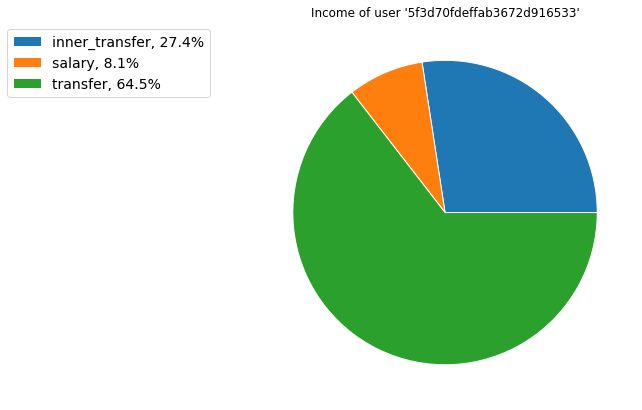

In [60]:
income_df = test_user_transactions_df.loc[test_user_transactions_df["is_income"]==True].reset_index(drop=True)
aggregated_income = aggregate_on_classification(income_df)
plot_pie(aggregated_income, "Income of user '5f3d70fdeffab3672d916533'")

### Expditure visualization

In [61]:
def count_dropped_transactions(transactions_df, user):
    dropped = transactions_df.loc[(transactions_df["user"]==user) & ((transactions_df["type"]=="card") | (transactions_df["type"]=="debit")) & (transactions_df["duplicated_with"].notna())].reset_index(drop=True)
    return len(dropped)


/Users/stavrostheocharis/projects/wyre/.env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [62]:
count = str(count_dropped_transactions(new_flagged_transactions_df, "5f3d70fdeffab3672d916533"))

/Users/stavrostheocharis/projects/wyre/.env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


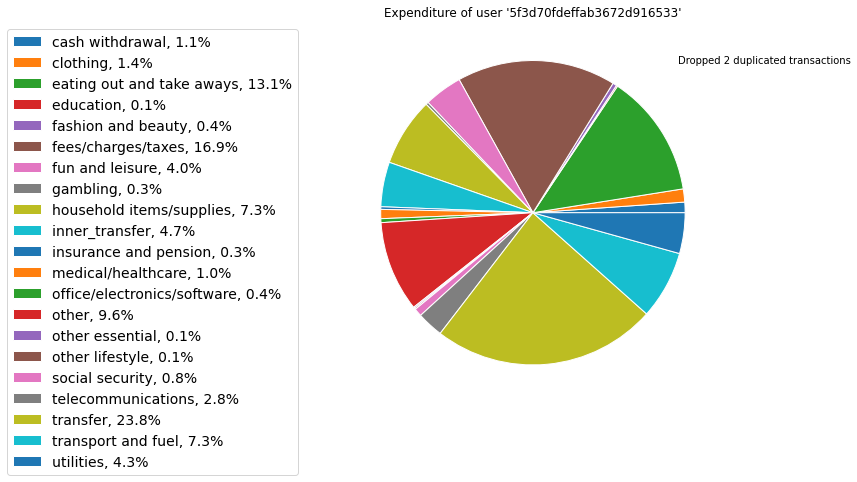

In [63]:
expediture_df = test_user_transactions_df.loc[test_user_transactions_df["is_income"]==False].reset_index(drop=True)
aggregated_expediture_df = aggregate_on_classification(expediture_df)
plot_pie(aggregated_expediture_df, "Expenditure of user '5f3d70fdeffab3672d916533'", "Dropped "+count+" duplicated transactions")

#### Other category has a high number because there are many simple remittance transfers in this dataset

### Let's go deeper and split expenses to cards and remittances

#### Find another user to test

In [64]:
test_user_transactions_df = transactions_to_use[transactions_to_use["user"]=="5f55f29a9479a65e972a5633"].reset_index(drop=True)

/Users/stavrostheocharis/projects/wyre/.env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Split test user transactions to income, card expenses and remittance expenses in order to visualize them separately

In [58]:
income_df = test_user_transactions_df.loc[test_user_transactions_df["is_income"]==True].reset_index(drop=True)
expediture_df = test_user_transactions_df.loc[test_user_transactions_df["is_income"]==False].reset_index(drop=True)

card_expenses_df = expediture_df.loc[(expediture_df["type"]=="card") | (expediture_df["type"]=="debit")].reset_index(drop=True)
remittance_expenses_df = expediture_df.loc[(expediture_df["type"]!="card") & (expediture_df["type"]!="debit")].reset_index(drop=True)


/Users/stavrostheocharis/projects/wyre/.env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Income visualization

/Users/stavrostheocharis/projects/wyre/.env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


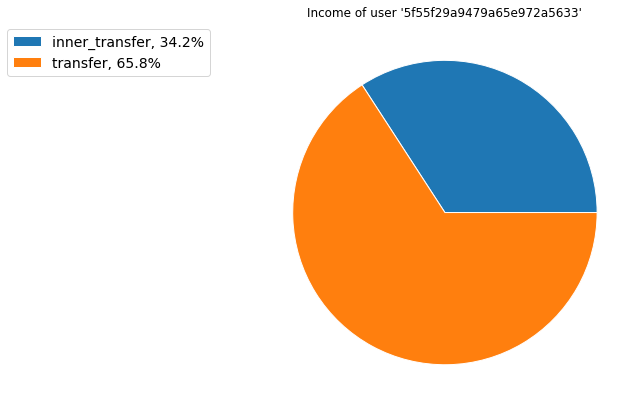

In [65]:
income_df = test_user_transactions_df.loc[test_user_transactions_df["is_income"]==True].reset_index(drop=True)
aggregated_income = aggregate_on_classification(income_df)
plot_pie(aggregated_income, "Income of user '5f55f29a9479a65e972a5633'")

In [66]:
count = str(count_dropped_transactions(new_flagged_transactions_df, "5f55f29a9479a65e972a5633"))

/Users/stavrostheocharis/projects/wyre/.env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


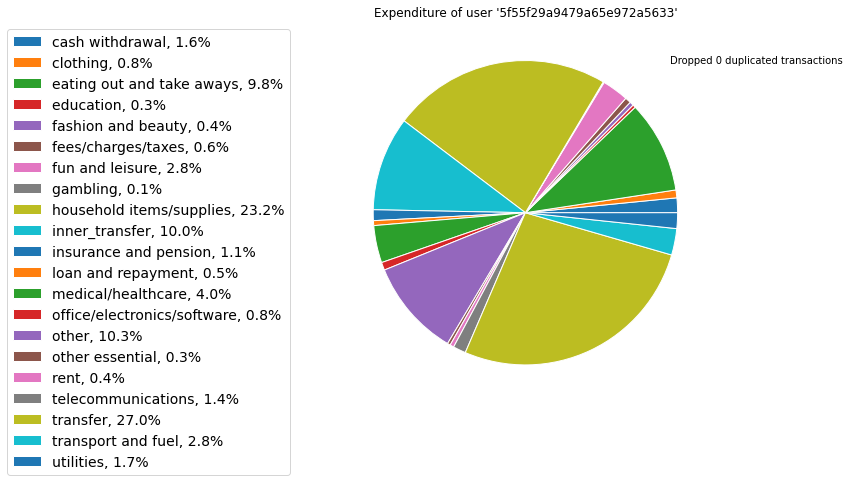

In [67]:
expediture_df = test_user_transactions_df.loc[test_user_transactions_df["is_income"]==False].reset_index(drop=True)
aggregated_expediture = aggregate_on_classification(expediture_df)
plot_pie(aggregated_expediture, "Expenditure of user '5f55f29a9479a65e972a5633'", "Dropped "+count+" duplicated transactions")

### Find another user

In [68]:
test_user_transactions_df = transactions_to_use[transactions_to_use["user"]=="5f5626c59479a659f72a5a88"].reset_index(drop=True)

/Users/stavrostheocharis/projects/wyre/.env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


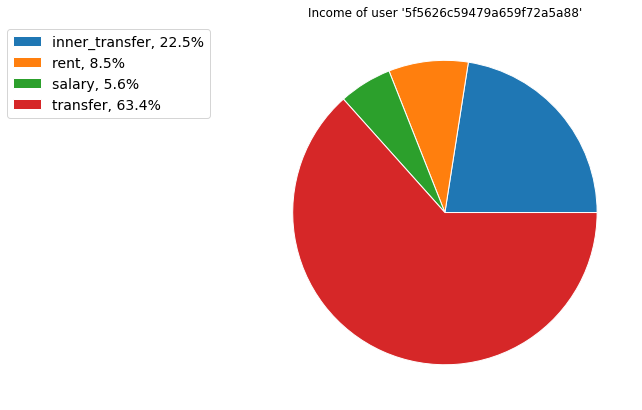

In [69]:
income_df = test_user_transactions_df.loc[test_user_transactions_df["is_income"]==True].reset_index(drop=True)
aggregated_income = aggregate_on_classification(income_df)
plot_pie(aggregated_income, "Income of user '5f5626c59479a659f72a5a88'")

In [70]:
count = str(count_dropped_transactions(new_flagged_transactions_df, "5f5626c59479a659f72a5a88"))

/Users/stavrostheocharis/projects/wyre/.env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


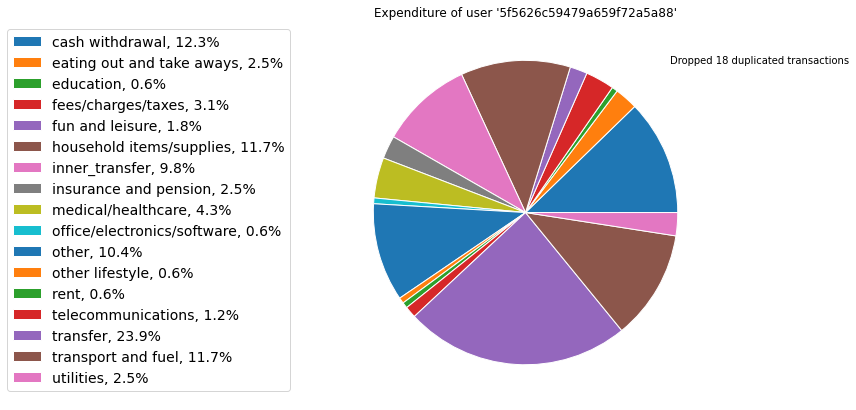

In [71]:
expediture_df = test_user_transactions_df.loc[test_user_transactions_df["is_income"]==False].reset_index(drop=True)
aggregated_expediture = aggregate_on_classification(expediture_df)
plot_pie(aggregated_expediture, "Expenditure of user '5f5626c59479a659f72a5a88'", "Dropped "+count+" duplicated transactions")

### Card expenses visualization

In [42]:
#aggregated_card_expenses_df = aggregate_on_classification(card_expenses_df)
#plot_pie(aggregated_card_expenses_df)

/Users/stavrostheocharis/projects/wyre/.env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Remittances visualization

In [43]:
#aggregated_remittance_expenses_df = aggregate_on_classification(remittance_expenses_df)
#plot_pie(aggregated_remittance_expenses_df)

## Need to mention

* Wysely has different approaches for classifying income and expediture (expediture is splitted to card & remittance)

* Some of the transactions were dropped. The reason is that expediture transactions need to match with an account, in order to find their type (card:"debit","credit","card" or account:"checking", "saving", "other"). We do not have the same issue for income.

* Banks that provide cards and simple accounts separately, provide also the cards' transactions twice. As also found in infin8's data this leads to wrong classification of card transactions (because they fall under "checking" or "saving" type and not as cards). This is the reason for example that through a description, we may look for a card but the type is wrong and we get wrong classification. If we have the full picture of transactions, we can bypass this problem by excluding these transactions and classify them with the appropriate method once.

* In the only bank (out of the 4 main banks in Greece Alpha, NBG, Piraeus, Eurobank) that currently Wysely cannot classify with high success transactions is Eurobank, because does not indicate cards (this is probably going to be changed in the future).

* Revolut's, ingdirect's and N26's transaction classification has been done through the general classification pipeline. That's why there is a weak success rate in those banks. We are currently building an approach for Revolut.

* Wysely has a high success rate in classifying income and card expediture (when a card can be identified)

* Mcc code functionality has been developed in wysely's approach. This means that when a bank provides mcc code for card expediture, we have full confidence of the clasasification result (currently alpha bank and piraeus bank provide mcc codes and we can match all of the existing mcc codes with wysely's categories)

In [45]:
new_flagged_transactions_df.to_csv(r'Classified_infin8_transactions.csv', index = False)


/Users/stavrostheocharis/projects/wyre/.env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [72]:
test = pd.read_csv("../notebooks/Classified_infin8_transactions.csv")

/Users/stavrostheocharis/projects/wyre/.env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [73]:
eurobank = test.loc[test["bank"]=="eurobank"].reset_index(drop=True)
nbg = test.loc[test["bank"]=="nbg"].reset_index(drop=True)
other = test.loc[(test["bank"]!="eurobank") & (test["bank"]!="nbg")].reset_index(drop=True)

final_df = pd.DataFrame()
final_df = final_df.append(nbg, ignore_index=True) 
final_df = final_df.append(eurobank, ignore_index=True) 
final_df = final_df.append(other, ignore_index=True) 

final_df.to_csv(r'Classified_infin8_transactions.csv', index = False)


/Users/stavrostheocharis/projects/wyre/.env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/stavrostheocharis/projects/wyre/.env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


provider_id                      user     bank  amount  \
0      5ffa61b38567db7d24e86916  5f7448032d4790bb9a5ab203      nbg  934.19   
1      5ffa61b38567db6c21e86917  5f7448032d4790bb9a5ab203      nbg    7.32   
2      5fee8477283d5c9d76fdbd51  5f7448032d4790bb9a5ab203      nbg    0.22   
3      5fe0acbf283d5c6bfffdbbbb  5f7448032d4790bb9a5ab203      nbg  965.43   
4      5fd2d54c283d5ca44afdb983  5f7448032d4790bb9a5ab203      nbg  934.19   
...                         ...                       ...      ...     ...   
20398  5f67063bec036e4a986fa1a0  5f670458ec036e67456f9fd6  revolut    5.00   
20399  5f67063aec036e3fe06fa072  5f670458ec036e67456f9fd6  revolut  100.00   
20400  5f560c2b9479a659892a5890  5f560b6d9479a66b1f2a5887  piraeus   19.58   
20401  5f560c2b9479a6ebb92a5891  5f560b6d9479a66b1f2a5887  piraeus    0.40   
20402  5f560c2b9479a68a752a5895  5f560b6d9479a66b1f2a5887  piraeus    0.14   

       balance                                        description  \
0      7940.27  ΜΙΣΘΟΔΟΣΙΑ ΔΕΚΕΜΒΡΙΟΣ 2020 ΑΠΟΣΤΟΛΑΚΗΣ ΚΩΝΣΤΑΝ...   
1      7006.08  ΜΙΣΘΟΔΟΣΙΑ ΕΠΙΔΟΜΑ ΑΔΕΙΑΣ 2 ΔΕΚΕΜΒΡΙΟΣ 2020 ΑΠ...   
2      7449.74                                   ΠΙΣΤΩΤΙΚΟΙ ΤΟΚΟΙ   
3      7738.19  ΜΙΣΘΟΔΟΣΙΑ ΔΩΡΟ ΧΡΙΣΤΟΥΓΕΝΝΩΝ 2020 ΑΠΟΣΤΟΛΑΚΗΣ...   
4      6961.92  ΜΙΣΘΟΔΟΣΙΑ ΝΟΕΜΒΡΙΟΣ 2020 ΑΠΟΣΤΟΛΑΚΗΣ ΚΩΝΣΤΑΝΤ...   
...        ...                                                ...   
20398     5.00                                 Exchanged from EUR   
20399   100.00                                    Top-Up by *0009   
20400  9463.84     CREDIT\nΟΠΕΚΕΠΕ ΑΜΕΣΕΣ ΕΝΙΣΧΥΣΕΙΣ\r\nΚΜΠ 09180   
20401  9444.26                                    INTEREST PAID\n   
20402  1422.31                                    INTEREST PAID\n   

                            date currency  is_income  \
0      2021-01-09 00:00:00+00:00      EUR       True   
1      2021-01-09 00:00:00+00:00      EUR       True   
2      2020-12-31 00:00:00+00:00      EUR       True   
3      2020-12-21 00:00:00+00:00      EUR       True   
4      2020-12-10 00:00:00+00:00      EUR       True   
...                          ...      ...        ...   
20398  2019-09-18 00:00:00+00:00      GBP       True   
20399  2019-09-17 00:00:00+00:00      EUR       True   
20400  2020-07-01 00:00:00+00:00      EUR       True   
20401  2020-06-30 00:00:00+00:00      EUR       True   
20402  2020-06-30 00:00:00+00:00      EUR       True   

                                       iban type  mcc classification  \
0      9685fd2a-8ed7-b428-b410-17a8cf20cc65  NaN  NaN         salary   
1      9685fd2a-8ed7-b428-b410-17a8cf20cc65  NaN  NaN         salary   
2      9685fd2a-8ed7-b428-b410-17a8cf20cc65  NaN  NaN       transfer   
3      9685fd2a-8ed7-b428-b410-17a8cf20cc65  NaN  NaN         salary   
4      9685fd2a-8ed7-b428-b410-17a8cf20cc65  NaN  NaN         salary   
...                                     ...  ...  ...            ...   
20398                  LT413250000000000000  NaN  NaN       transfer   
20399                  LT413250000000000000  NaN  NaN       transfer   
20400           GR3201712860006286010417255  NaN  NaN       transfer   
20401           GR3201712860006286010417255  NaN  NaN       transfer   
20402           GR6201721530005153035266754  NaN  NaN       transfer   

       confidence duplicated_with  is_inner  
0        0.876829             NaN     False  
1        0.876829             NaN     False  
2        0.999830             NaN     False  
3        0.876829             NaN     False  
4        0.876829             NaN     False  
...           ...             ...       ...  
20398    0.980058             NaN     False  
20399    0.769408             NaN     False  
20400    0.941029             NaN     False  
20401    0.769408             NaN     False  
20402    0.769408             NaN     False  

[20403 rows x 16 columns]